In [ ]:
pip install category_encoders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay,make_scorer, f1_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.model_selection import GridSearchCV

In [2]:
my_recall_results = []

# Function to extract recall values for both classes from confusion matrix
def extract_recall_from_confusion_matrix(conf_matrix):
    recall_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    recall_class_1 = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    precision_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    precision_class_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    return recall_class_0, recall_class_1,precision_class_0, precision_class_1

# We are creating two helper functions, both of which will need to predict class labels.
# Factor the code into one function rather than duplicating it.
def predict_class_labels(classifier,X_train,y_train,X_test): 
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

#This function will display the full results (confusion matrix, classification report)
def display_model_results_full(title,classifier,X_train,y_train,X_test,y_test, isAddResult = True):
    print(title + ' Results')
    y_pred = predict_class_labels(classifier,X_train,y_train,X_test)
    cm = confusion_matrix(y_test, y_pred)
    recall_class_0, recall_class_1,precision_class_0, precision_class_1 = extract_recall_from_confusion_matrix(cm)
    if isAddResult:
        my_recall_results.extend([(title, recall_class_0, recall_class_1,precision_class_0,precision_class_1)]) 
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_).plot()
    plt.title('Confusion Matrix')
    # Display the classification report
    print(classification_report(y_test, y_pred))



In [3]:
# Import the data...
df = pd.read_csv("bs140513_032310.csv")
#df = df.iloc[:1000]
print(df.describe())

                step         amount          fraud
count  594643.000000  594643.000000  594643.000000
mean       94.986827      37.890135       0.012108
std        51.053632     111.402831       0.109369
min         0.000000       0.000000       0.000000
25%        52.000000      13.740000       0.000000
50%        97.000000      26.900000       0.000000
75%       139.000000      42.540000       0.000000
max       179.000000    8329.960000       1.000000


(594643 Records, 10 Features)
3 columns with numerical data and rest are in strings.Let us look in depth of data to know what it have.

In [4]:
unique_entries = df['step'].unique()
print(unique_entries)
unique_entries = df['customer'].nunique()
print(unique_entries)
unique_entries = df['age'].unique()
print(unique_entries)
unique_entries = df['zipcodeOri'].unique()
print(unique_entries)
unique_entries = df['merchant'].nunique()
print(unique_entries)
unique_entries = df['zipMerchant'].unique()
print(unique_entries)
unique_entries = df['category'].unique()
print(unique_entries)
unique_entries = df['amount'].unique()
print(unique_entries)
unique_entries = df['fraud'].unique()
print(unique_entries)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
4112
["'4'" "'2'" "'3'" "'5'" "'1'" "'6'" "'U'" "'0'"]
["'28007'"]
50
["'28007'"]
["'es_transportation'" "'es_health'" "'es_otherservices'" "'es_food'"
 "'es_hotelservices'" "'es_barsandrestaurants'" "'es_tech'"
 "'es_sportsandtoys'" "'es_wellnessandbeauty'" "'es_hyper

Here ZipCodePri and ZipCode Merchant are constant columns typically doesn't 
contribute any useful information for predictive modeling. Removing such columns is a
good practice as they don't add variability to the dataset and won't assist the model 
in learning patterns or making predictions.So I am removing both features

In [5]:

# Check for constant columns (columns with only one unique value)
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
# Drop constant columns from the DataFrame
df.drop(columns=constant_columns, inplace=True)

Let us divide the target column from rest of the features.

In [6]:
X = df.drop('fraud', axis=1)
y = df['fraud']

Let me encode the customer and merchant with their frequency rather than one hot encoding because it will add up so much columns.

In [7]:
# Frequency encoding for 'Customer' and 'Merchant' codes
for col in ['customer', 'merchant']:
    frequency_encoding = X[col].value_counts()  # Calculate frequency of each code
    X[col] = X[col].map(frequency_encoding)  # Map frequency values to original codes = 

In [8]:

one_hot_cols = ['gender', 'category','age']

# Apply one-hot encoding using ColumnTransformer and Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), one_hot_cols)
    ],
    remainder='passthrough'
)
X_Transformed = preprocessor.fit_transform(X)


(594643, 31)


<Axes: ylabel='count'>

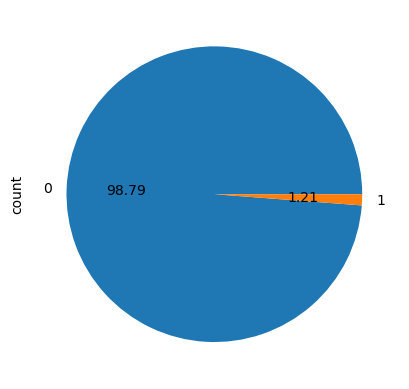

In [9]:
print(X_Transformed.shape)
y.value_counts().plot.pie(autopct='%.2f')

It is clear from our pie chart that our data is highly imbalance but our problem is of binary classification. SVM is not suitable in highy imbalance data set because of its initial hypothesis of division line between both positive and negative classes as discussed by [2] 2nd reference (Applying Support Vector Machines to Imbalanced Datasets) so I am going to apply 
MLPClassifier and look at the results.

MLP Classifier before Encoding data Results
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    117512
           1       0.93      0.40      0.56      1417

    accuracy                           0.99    118929
   macro avg       0.96      0.70      0.78    118929
weighted avg       0.99      0.99      0.99    118929



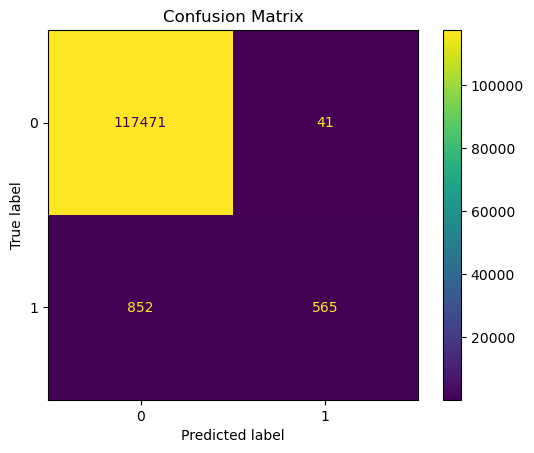

In [10]:

X_train, X_test, y_train, y_test = train_test_split(X_Transformed, y, test_size=0.2, random_state=42)
display_model_results_full('MLP Classifier before Encoding data',MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42),X_train,y_train,X_test,y_test)

Here even the system is predicting with an accuracy of 0.99% but our system is working very badly in detecting fraud with recall of 40% let is it due to imbalance of data or some feature issue?

Encompassing a dataset with 594,643 rows and featuring categorical variables such as 'merchant' (consisting of 50 distinct entries) and 'customer' (spanning across 4,112 unique entries), the significance of effective encoding strategies for high-cardinality categorical features is paramount.Hence, due to size and the nature of 'merchant' and 'code' with their extensive number of unordered levels, leveraging target encoding technique will turn out to be good approach because ohe hot encoding 
will add so much columns and wont be considered a good approach for learning for high cardinality columns merchant and customer.
Let us try to change the features merchant and customer and then check the results?

In [11]:
X = df.drop('fraud', axis=1)
y = df['fraud']
encoder = ce.TargetEncoder(cols=['merchant', 'customer'])
X_Transformed = encoder.fit_transform(X, y)

one_hot_cols = ['gender', 'category','age']
# Apply one-hot encoding using ColumnTransformer and Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), one_hot_cols)
    ],
    remainder='passthrough'
)
X_Transformed = preprocessor.fit_transform(X_Transformed)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_Transformed, y, test_size=0.2, random_state=42) #(80,20) ratio for seen and unseen data


MLP Classifier  Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117512
           1       0.89      0.83      0.86      1417

    accuracy                           1.00    118929
   macro avg       0.95      0.91      0.93    118929
weighted avg       1.00      1.00      1.00    118929



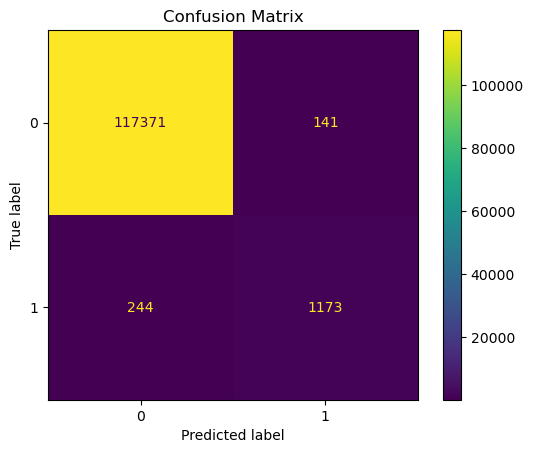

In [13]:
display_model_results_full('MLP Classifier ',MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42),X_train,y_train,X_test,y_test, isAddResult = False)

Recall will be considered as performance metrice because we have to consider both i.e fraud or not fraud is detected properly. . It's useful when the class distribution is imbalanced as in our case. so my Recall is improved from (1, 0.40) to (1, 0.83) while precision is (1, 0.89) respectively which is a pretty enhanced result so target encoding played significant role in improving our learning.Now, I am going to use grid search to find optimal hyper parameter set plus to validate whether is their were any over fiting introduced by my split of training and testing data set? 


# Define the parameter grid
param_grid_mlp= {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Create MLPClassifier
mlp = MLPClassifier(random_state=42)

# Define F1 score as the scoring metric focusing on the positive class
recall_positive = make_scorer(recall_score, pos_label=1) 
# As I am more interested in improving Recall score of positive class because model is already giving Recall score of 100% for Negative class SO my target is to optimise 
# Perform GridSearchCV using F1 score for the positive class as the scoring metric
grid_search = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring=recall_positive) 
grid_search.fit(X_Transformed, y)

# Get the best parameters and best score for the positive class
best_params = grid_search.best_params_
best_score = grid_search.best_score_

display_model_results_full('Best possible MLP Classifier ',MLPClassifier(**best_params,random_state=42),X_train,y_train,X_test,y_test)

Best possible MLP Classifier  Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117512
           1       0.82      0.87      0.85      1417

    accuracy                           1.00    118929
   macro avg       0.91      0.94      0.92    118929
weighted avg       1.00      1.00      1.00    118929



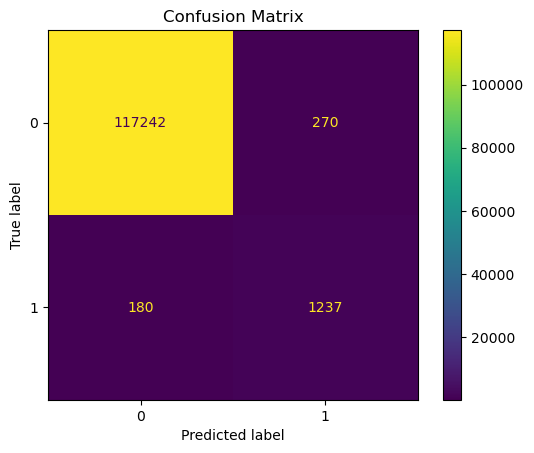

In [14]:
best_params = {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
display_model_results_full('Best possible MLP Classifier ',MLPClassifier(**best_params,random_state=42),X_train,y_train,X_test,y_test)

 As my result not increased significantly i/e just changed from (1,0.83) to (1,0.87) keeping precision to (1,0.82) giving best possible subset of given params to MLP I have to look at some other technique as it is due to imbalance data set.Ensemble method generally works really well in handling imbalance data because of their ability to make diverse sets for each tree through boot strapping and bagging, they have an ability to develop diverse subset to mitigate class imbalance issues(A novel ensemble method for classifying imbalanced data. Pattern Recognition). Random Forest is among the one of the ensemble method which is base on decision tree which runs multiple algorithms in parallel with weak hypothesis and then combine them to increase the performance of model. 

Random Forest Classifier Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117512
           1       0.90      0.86      0.88      1417

    accuracy                           1.00    118929
   macro avg       0.95      0.93      0.94    118929
weighted avg       1.00      1.00      1.00    118929



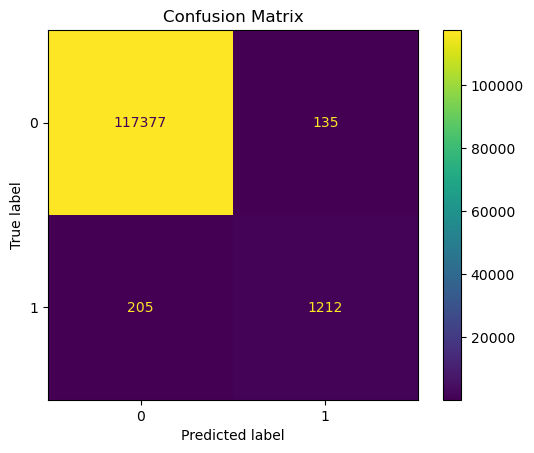

In [15]:
display_model_results_full('Random Forest Classifier',RandomForestClassifier(n_estimators=500, random_state=42),X_train,y_train,X_test,y_test)

Random Forest did not have a major difference in recall but improved the precision of 9% from 82% to 90%.BalancedRandomForestClassifier in the imbalanced-learn library, extends the RandomForestClassifier by incorporating techniques to handle imbalanced data. It introduces balancing mechanisms within each bootstrap sample by resampling the dataset during the tree construction process. This technique aims to ensure a more balanced representation of classes in each tree, which can improve performance on imbalanced datasets. Let us try this one

Balanced Random Forest Classifier Results


C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    117512
           1       0.39      1.00      0.57      1417

    accuracy                           0.98    118929
   macro avg       0.70      0.99      0.78    118929
weighted avg       0.99      0.98      0.99    118929



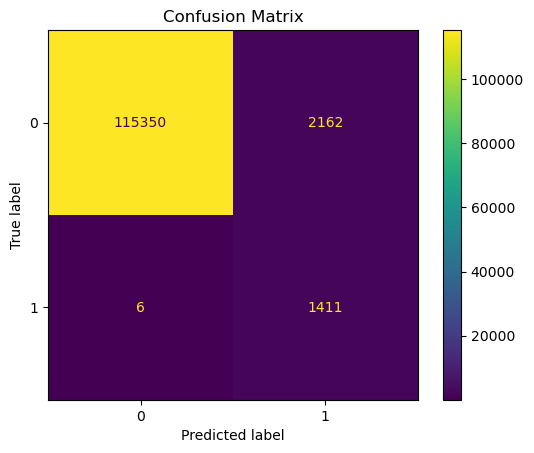

In [16]:
from imblearn.ensemble import BalancedRandomForestClassifier
display_model_results_full('Balanced Random Forest Classifier',BalancedRandomForestClassifier(n_estimators=500, random_state=42),X_train,y_train,X_test,y_test,isAddResult = False)

Here the balanced Random Tree improved our results from 0.86 to 1 which is a wonderful 14% increase in detecting fraud.
but it decreases the recall of not having fraud to 1 to 0.98 so it is almost a give and take with overall accuracy of 
100% so it is a wonderful result but precision of detecting fraud is significantly dropped to  0.39. Let us find the most optimal tree length for this model.
Let us try to have some voting among them so may be we could still get same results without compromising in recall of not detecting fraud.

param_grid_mlp= {
    'n_estimators': [100,200,300,400,500]
                }

random_forest = BalancedRandomForestClassifier(random_state=42)

# Define Recall score as the scoring metric focusing on the positive class
recall_positive = make_scorer(recall_score, pos_label=1) # As I am more interested in improving F1 score of positive class because model # is already giving F1 score of 1 for Neative class

# Perform GridSearchCV using Recall score for the positive class as the scoring metric
grid_search = GridSearchCV(random_forest, param_grid_mlp, cv=5, scoring=recall_positive) 
grid_search.fit(X_Transformed, y)

# Get the best parameters and best score for the positive class
best_params_rf= grid_search.best_params_ 
best_score = grid_search.best_score_



In [17]:
best_params_rf = {'n_estimators': 300}


Now Running the Balance Tree with these params

Best Balanced Random Forest Classifier given parameters Results


C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    117512
           1       0.40      1.00      0.57      1417

    accuracy                           0.98    118929
   macro avg       0.70      0.99      0.78    118929
weighted avg       0.99      0.98      0.99    118929



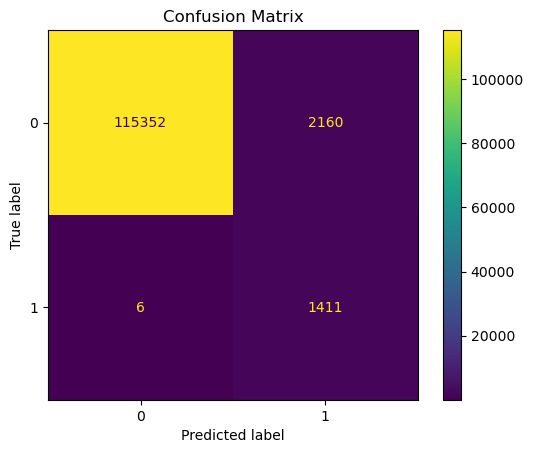

In [18]:
display_model_results_full('Best Balanced Random Forest Classifier given parameters',BalancedRandomForestClassifier(**best_params_rf, random_state=42),X_train,y_train,X_test,y_test)

Even after finding the optimal hyper parameter their is no significant change in our performance metrices.
Let us try to have some voting among them so may be we could still get same results without compromising
in recall of not detecting fraud which is affecting  precision of detecting fraud heavily due to imbalance of data.


Soft Voting Ensemble Results


C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    117512
           1       0.66      0.97      0.79      1417

    accuracy                           0.99    118929
   macro avg       0.83      0.98      0.89    118929
weighted avg       1.00      0.99      0.99    118929



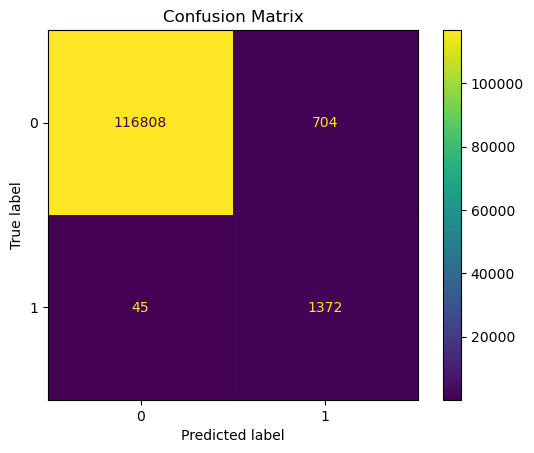

In [19]:
mlp = MLPClassifier(**best_params)
rf =  RandomForestClassifier(n_estimators=500, random_state=42)
brf = BalancedRandomForestClassifier(**best_params_rf, random_state=42)
weights = [1,1,2] # Because I got best and balanced result through balanced Random Forest giving 
                # it some priority in decision of output
voting_classifier = VotingClassifier(estimators=[('mlp', mlp), ('rf', rf), ('brf', brf)], voting='soft', weights=weights)
display_model_results_full('Soft Voting Ensemble',voting_classifier,X_train,y_train,X_test,y_test)

Here through ensembler we traded off some recall of detecting fraud with precision now my system is successfully detecting fraud
and non fraud with 99% and 97% accuracy which is traded off among them from 100% and 98% but my precision to detect fraud increased from 39% to 67% which makes it to a good deal.

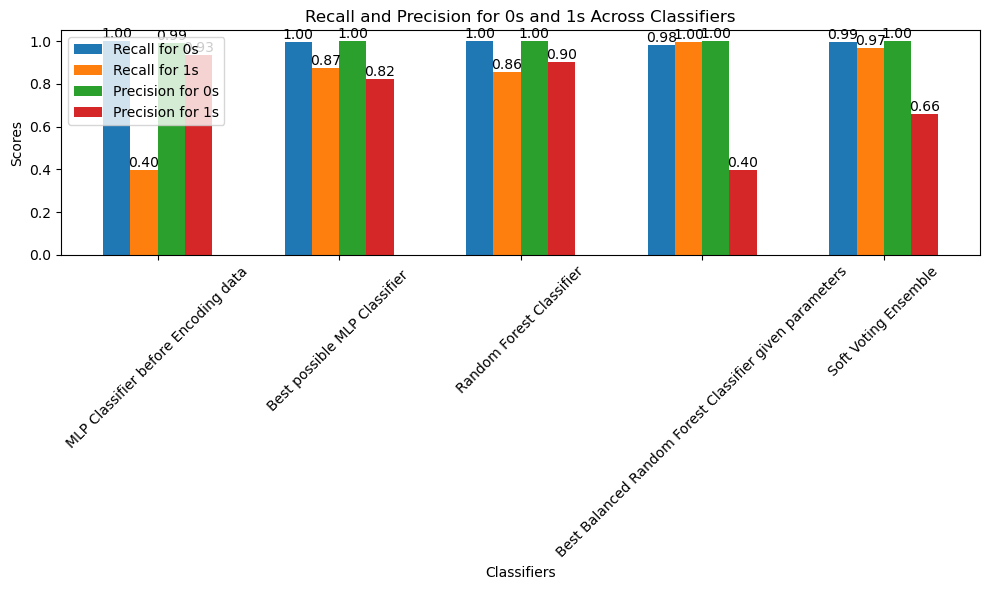

In [20]:
# Create bar chart
# Separate the data
def barGraphResults():
    classifier_names = [item[0] for item in my_recall_results[0:]]
    recall_0s = [item[1] for item in my_recall_results[0:]]
    recall_1s = [item[2] for item in my_recall_results[0:]]
    precision_0s = [item[3] for item in my_recall_results[0:]]  # Replace with your precision values for class 0
    precision_1s = [item[4] for item in my_recall_results[0:]]  # Replace with your precision values for class 1

    bar_width = 0.15
    index = range(len(classifier_names))

    fig, ax = plt.subplots(figsize=(10, 6))

    bar1 = ax.bar(index, recall_0s, bar_width, label='Recall for 0s')
    bar2 = ax.bar([i + bar_width for i in index], recall_1s, bar_width, label='Recall for 1s')
    bar3 = ax.bar([i + 2 * bar_width for i in index], precision_0s, bar_width, label='Precision for 0s')
    bar4 = ax.bar([i + 3 * bar_width for i in index], precision_1s, bar_width, label='Precision for 1s')
    ax.set_xlabel('Classifiers')
    ax.set_ylabel('Scores')
    ax.set_title('Recall and Precision for 0s and 1s Across Classifiers')
    ax.set_xticks([i + 1.5 * bar_width for i in index])
    ax.set_xticklabels(classifier_names, rotation=45)
    ax.legend()
        # Adding text inside the bars with original values
    for bars, scores in zip([bar1, bar2, bar3, bar4], [recall_0s, recall_1s, precision_0s, precision_1s]):
        for bar, score in zip(bars, scores):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
barGraphResults()

LEt us check the last two for seen and unseen data

In [21]:
#This function will display selected scores (f1-score macro average, accuracy)
def run_and_save_seen_unseen(title,classifier,X_train,y_train,X_test,y_test, isAddResult = True):
    model = classifier.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    cm_unseen = confusion_matrix(y_test, y_pred_test)
    cm_seen = confusion_matrix(y_train, y_pred_train)
    recall_class_0, recall_class_1,precision_class_0, precision_class_1 = extract_recall_from_confusion_matrix(cm_unseen)
    my_recall_results.extend([(title + 'Unseen Data', recall_class_0, recall_class_1,precision_class_0,precision_class_1)])
    recall_class_0, recall_class_1,precision_class_0, precision_class_1 = extract_recall_from_confusion_matrix(cm_seen)
    my_recall_results.extend([(title + 'Seen Data', recall_class_0, recall_class_1,precision_class_0,precision_class_1)])
    print(f'{title} is succesfully completed')

C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Soft Voting Ensemble is succesfully completed


C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\shahr\annaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Balanded RF with best params is succesfully completed


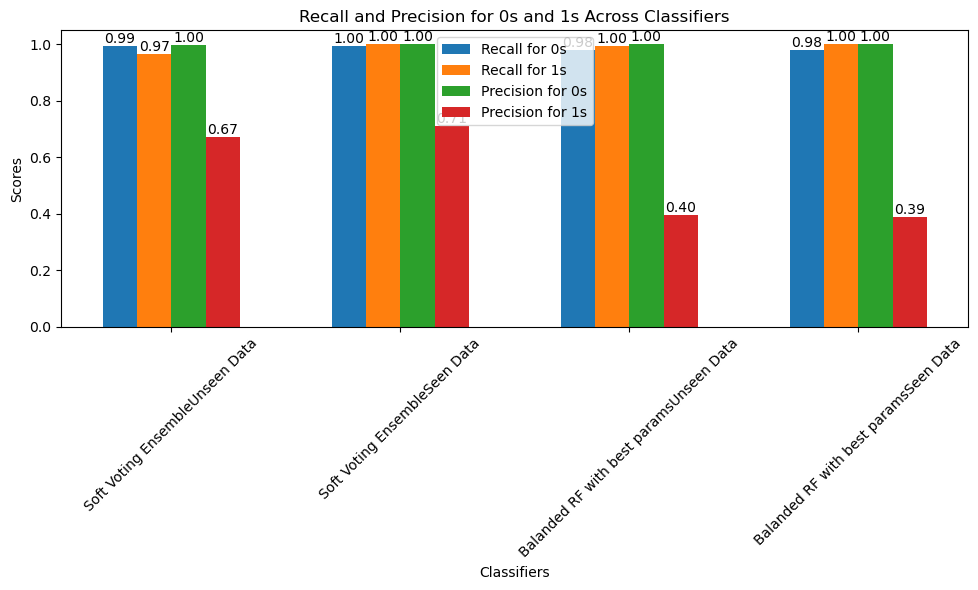

In [22]:
bm_1 = BalancedRandomForestClassifier(**best_params_rf, random_state=42)
bm_2 = VotingClassifier
my_recall_results = []
run_and_save_seen_unseen('Soft Voting Ensemble',voting_classifier,X_train,y_train,X_test,y_test)
run_and_save_seen_unseen('Balanded RF with best params',bm_1,X_train,y_train,X_test,y_test)
barGraphResults()


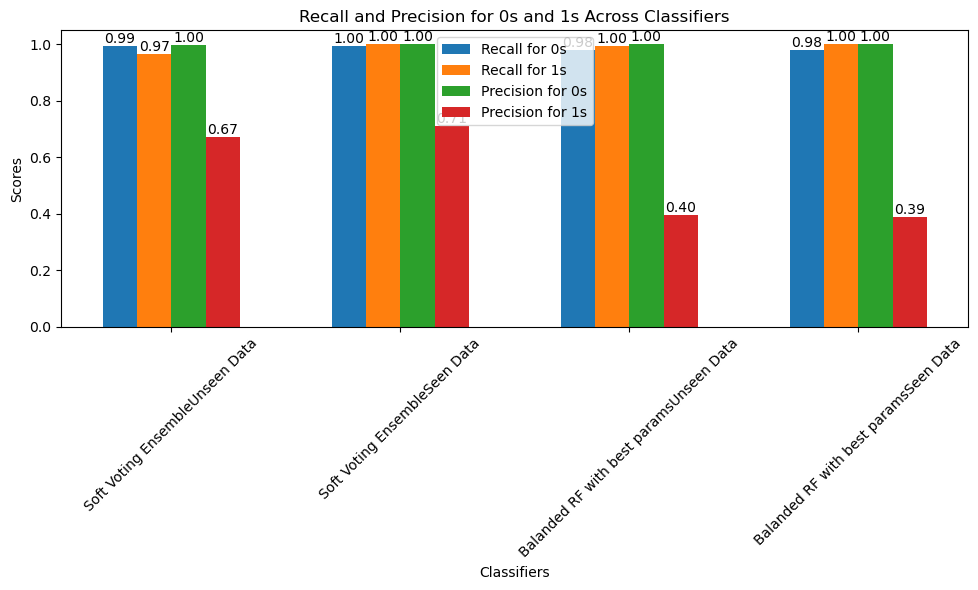

In [23]:
barGraphResults()

Here are results for unseen data (Soft Voting Ensemble):
Precision: 67%
Recall: 96% for class 1, 99% for class 0
Here are results for unseen data (BAlanced RF Ensemble):
Precision: 39%
Recall: 99.98% for class 1, 98% for class 0

If my target was of accurately detecting fraud then Balanced Random Forest would have worked significantly well with
accuracy of almost 100% which would have been selected but I was asked for both classes so result of soft Voting Providing me
the balance by improving the precision of 1's reducing the panic detection for fraud by a margin. So, it will be considered as
best model for my scenario as it traded some of Recall for positive class with precision as I was asked for both Fraud or not Fraud.

# {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
# {'n_estimators': 300}